In [19]:
import numpy as np
import pandas as pd
import os
import glob
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import skimage
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [2]:
import random

In [23]:
#removes warnings like version deprecation etc., I feel these warnings just disturb my flow if code so writing code to ignore them. This does not effect the functionality of code
import warnings
warnings.filterwarnings("ignore")

In [4]:
data_dir = "Dataset/"

In [5]:
data_labels = ["COVID", "Lung_Opacity", "Normal", "Viral_Pneumonia"]

# Set up paths to your image folders
covid_path = data_dir+"COVID/images"
covid_files = os.listdir(covid_path)
lung_opacity_path = data_dir+"Lung_Opacity/images"
lung_opacity_files = os.listdir(lung_opacity_path)
normal_path = data_dir+"Normal/images"
normal_files = os.listdir(normal_path)
viral_pneumonia_path = data_dir+"Viral Pneumonia/images"
viral_pneumonia_files = os.listdir(viral_pneumonia_path)

In [6]:
# define the folder paths for each set of images
covid_dir = data_dir+"COVID/images"
lung_opacity_dir = data_dir+"Lung_Opacity/images"
normal_dir = data_dir+"Normal/images"
viral_pneumonia_dir = data_dir+"Viral Pneumonia/images"

# get the file names for each image in each folder
covid_images = os.listdir(covid_dir)
lung_opacity_images = os.listdir(lung_opacity_dir)
normal_images = os.listdir(normal_dir)
viral_pneumonia_images = os.listdir(viral_pneumonia_dir)

covid_images.sort()
lung_opacity_images.sort()
normal_images.sort()
viral_pneumonia_images.sort()

covid_images_size = len(covid_images)
lung_opacity_images_size = len(lung_opacity_images)
normal_images_size = len(normal_images)
viral_pneumonia_images_size = len(viral_pneumonia_images)
counts = [covid_images_size, lung_opacity_images_size, normal_images_size, viral_pneumonia_images_size]

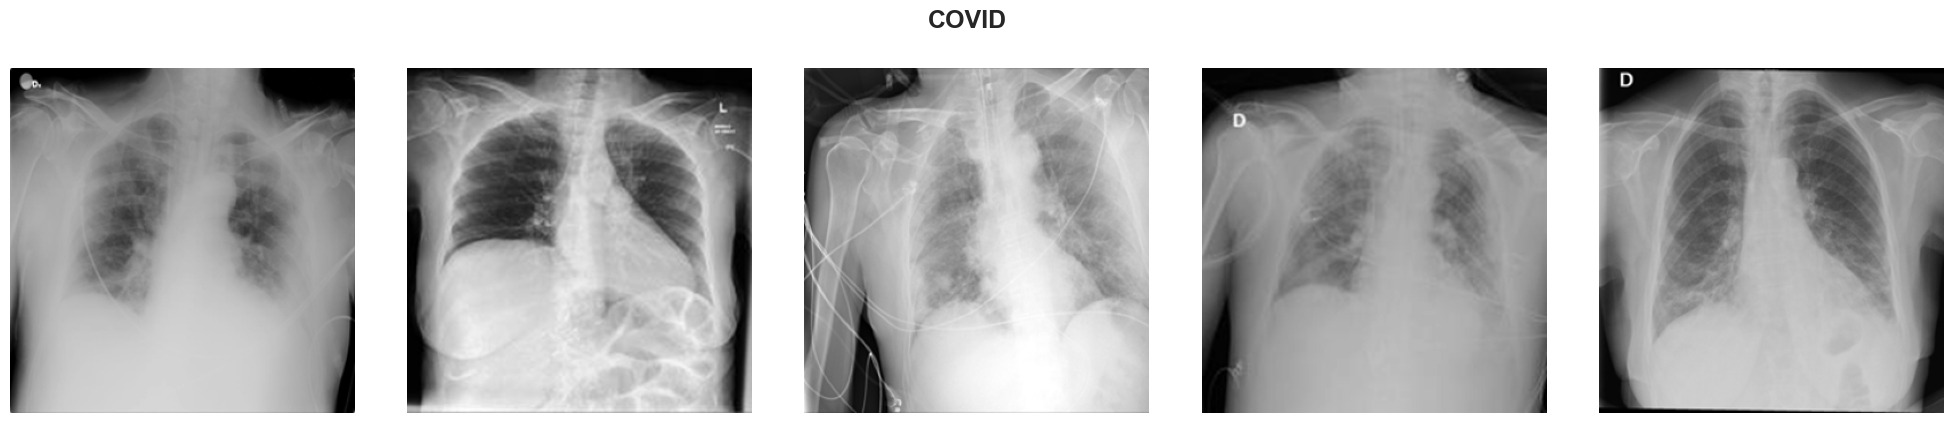

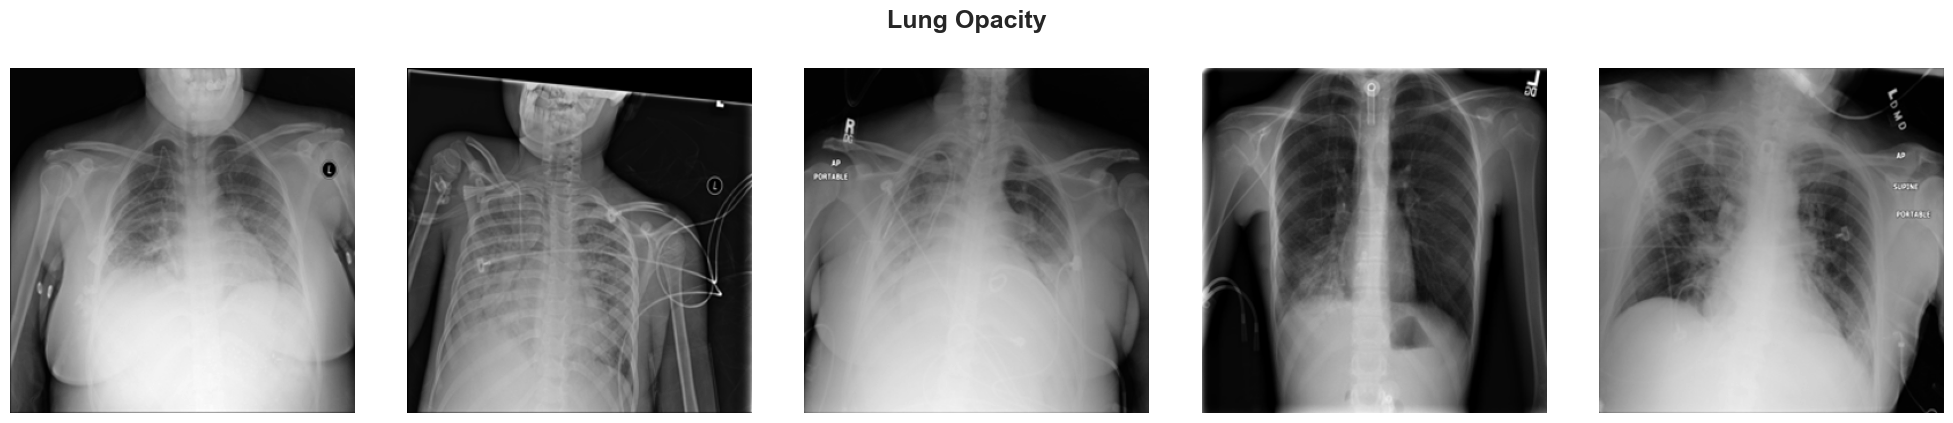

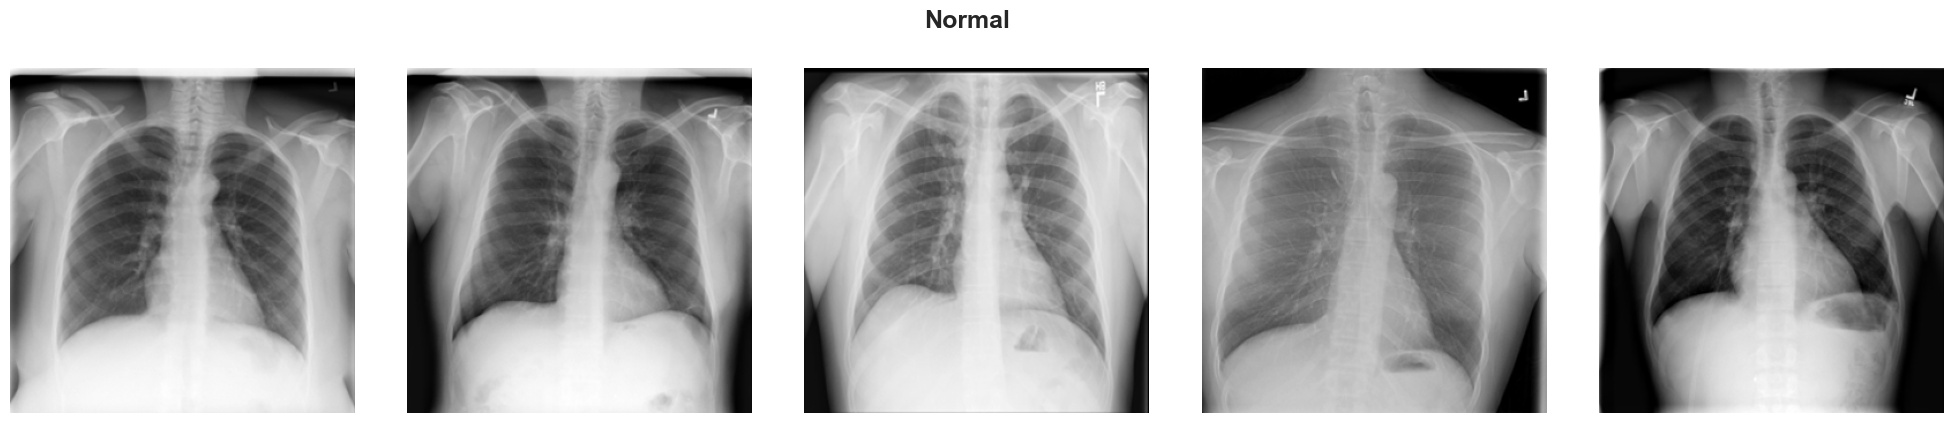

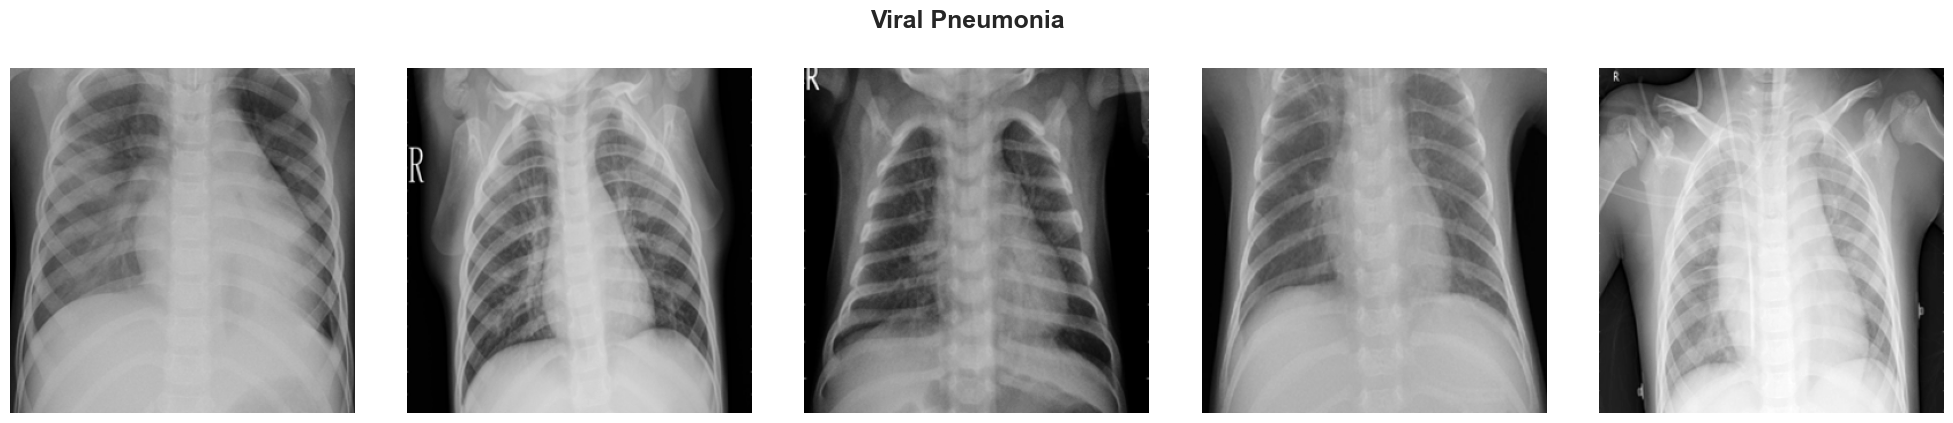

In [7]:
# Define a function to plot a set of images
def plot_images(image_dir, label):
    # Get a list of the filenames in the directory
    filenames = os.listdir(image_dir)
    # Take the first 5 filenames
    filenames = filenames[:5]
    # Plot each image in a subplot
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    fig.tight_layout(pad=1)
    fig.suptitle(label, fontsize=18, fontweight="bold")
    for i, filename in enumerate(filenames):
        img_path = os.path.join(image_dir, filename)
        img = plt.imread(img_path)
        axs[i].imshow(img, cmap = 'gray')
        axs[i].axis("off")
    plt.show()

# Plot the images for each set
plot_images(covid_dir, "COVID")
plot_images(lung_opacity_dir, "Lung Opacity")
plot_images(normal_dir, "Normal")
plot_images(viral_pneumonia_dir, "Viral Pneumonia")


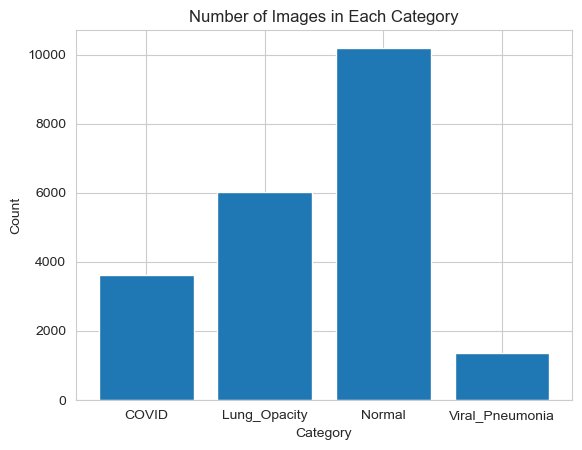

In [8]:
plt.bar(data_labels, counts)

# Set the title and axis labels
plt.title('Number of Images in Each Category')
plt.xlabel('Category')
plt.ylabel('Count')

# Display the chart
plt.show()

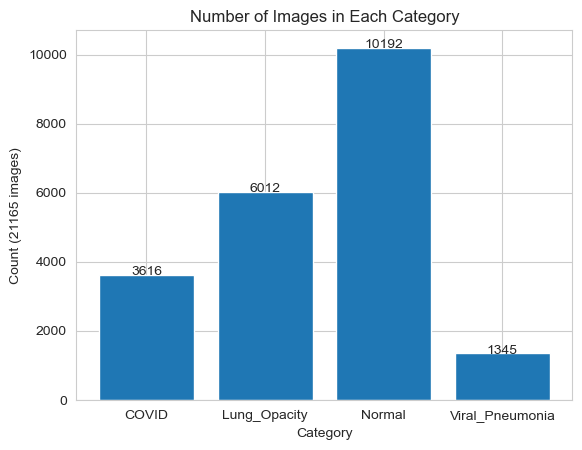

In [9]:
plt.bar(data_labels, counts)

# Set the title and axis labels
plt.title('Number of Images in Each Category')
plt.xlabel('Category')
plt.ylabel(f'Count ({sum(counts)} images)')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center')

# Display the chart
plt.show()



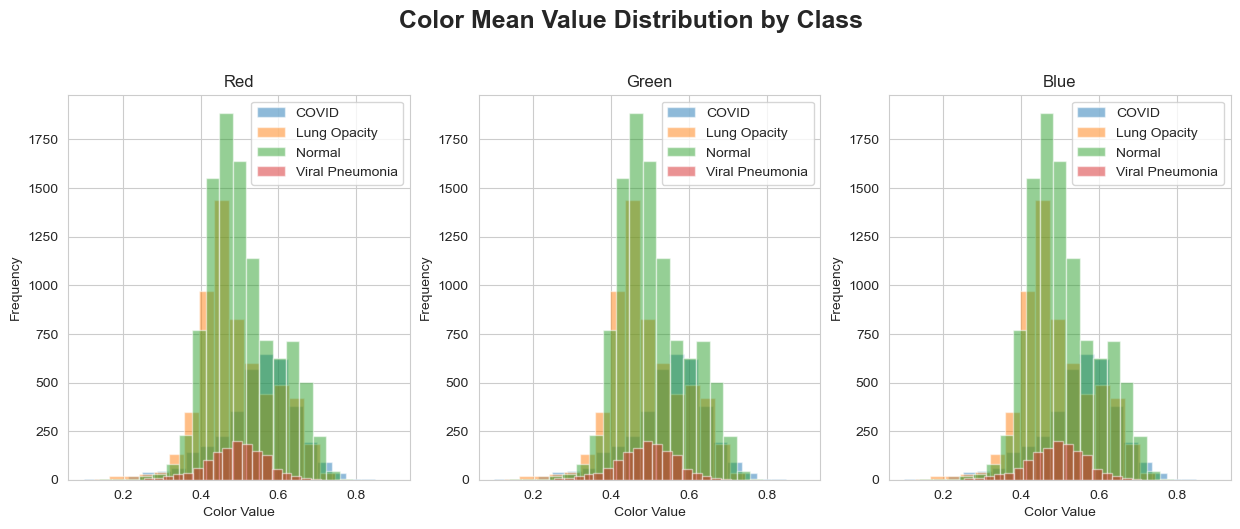

In [10]:
def calculate_mean_color(image_dir):
    red_mean_values = []
    green_mean_values = []
    blue_mean_values = []
    filenames = os.listdir(image_dir)
    for filename in filenames:
        img_path = os.path.join(image_dir, filename)
        img = plt.imread(img_path)
        if img.ndim == 2:  # Grayscale image
            red_mean_values.append(np.mean(img))
            green_mean_values.append(np.mean(img))
            blue_mean_values.append(np.mean(img))
        elif img.ndim == 3:  # RGB or RGBA image
            red_mean_values.append(np.mean(img[:, :, 0]))
            green_mean_values.append(np.mean(img[:, :, 1]))
            blue_mean_values.append(np.mean(img[:, :, 2]))
        else:
            raise ValueError(f"Unsupported image format: {img_path}")
    return red_mean_values, green_mean_values, blue_mean_values

# Calculate the mean color values for each class
covid_red, covid_green, covid_blue = calculate_mean_color(covid_dir)
lung_opacity_red, lung_opacity_green, lung_opacity_blue = calculate_mean_color(lung_opacity_dir)
normal_red, normal_green, normal_blue = calculate_mean_color(normal_dir)
viral_pneumonia_red, viral_pneumonia_green, viral_pneumonia_blue = calculate_mean_color(viral_pneumonia_dir)

# Plot histograms of the mean color values for each class
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Color Mean Value Distribution by Class", y=1.05, fontsize=18, fontweight="bold")
axs[0].hist(covid_red, bins=20, alpha=0.5, label="COVID")
axs[0].hist(lung_opacity_red, bins=20, alpha=0.5, label="Lung Opacity")
axs[0].hist(normal_red, bins=20, alpha=0.5, label="Normal")
axs[0].hist(viral_pneumonia_red, bins=20, alpha=0.5, label="Viral Pneumonia")
axs[0].set_title("Red")
axs[0].set_xlabel("Color Value")
axs[0].set_ylabel("Frequency")
axs[0].legend()

axs[1].hist(covid_green, bins=20, alpha=0.5, label="COVID")
axs[1].hist(lung_opacity_green, bins=20, alpha=0.5, label="Lung Opacity")
axs[1].hist(normal_green, bins=20, alpha=0.5, label="Normal")
axs[1].hist(viral_pneumonia_green, bins=20, alpha=0.5, label="Viral Pneumonia")
axs[1].set_title("Green")
axs[1].set_xlabel("Color Value")
axs[1].set_ylabel("Frequency")
axs[1].legend()

axs[2].hist(covid_blue, bins=20, alpha=0.5, label="COVID")
axs[2].hist(lung_opacity_blue, bins=20, alpha=0.5, label="Lung Opacity")
axs[2].hist(normal_blue, bins=20, alpha=0.5, label="Normal")
axs[2].hist(viral_pneumonia_blue, bins=20, alpha=0.5, label="Viral Pneumonia")
axs[2].set_title("Blue")
axs[2].set_xlabel("Color Value")
axs[2].set_ylabel("Frequency")
axs[2].legend()

plt.show()



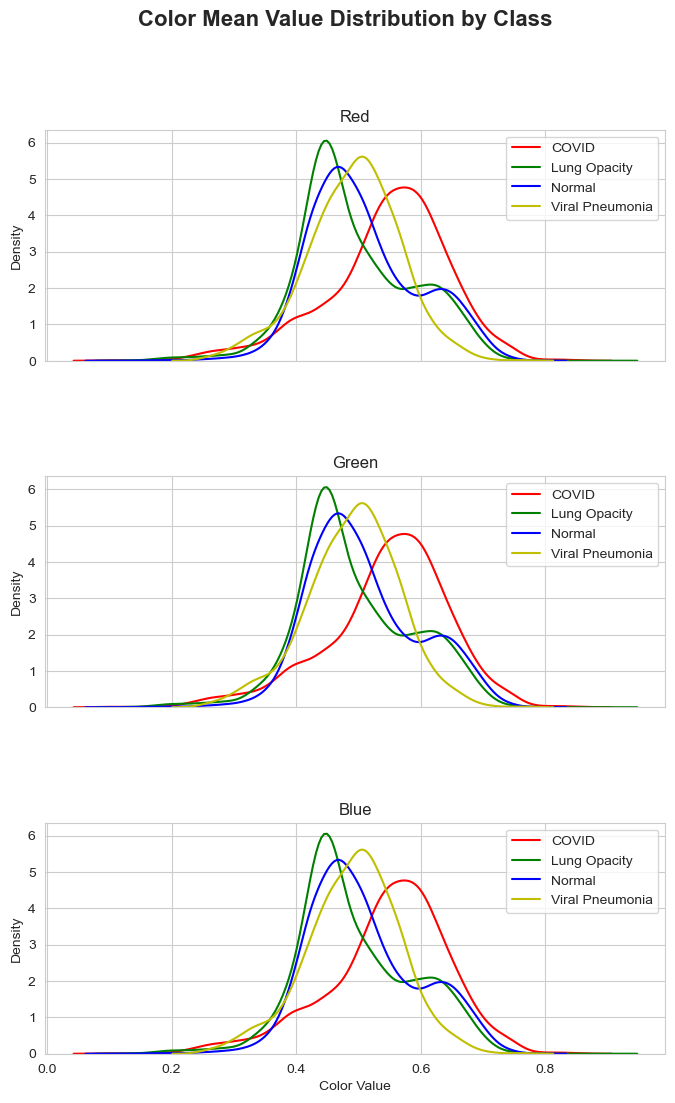

In [11]:

def calculate_mean_color(image_dir):
    red_mean_values = []
    green_mean_values = []
    blue_mean_values = []
    filenames = os.listdir(image_dir)
    for filename in filenames:
        img_path = os.path.join(image_dir, filename)
        img = plt.imread(img_path)
        if img.ndim == 2:  # Grayscale image
            red_mean_values.append(np.mean(img))
            green_mean_values.append(np.mean(img))
            blue_mean_values.append(np.mean(img))
        elif img.ndim == 3:  # RGB or RGBA image
            red_mean_values.append(np.mean(img[:, :, 0]))
            green_mean_values.append(np.mean(img[:, :, 1]))
            blue_mean_values.append(np.mean(img[:, :, 2]))
        else:
            raise ValueError(f"Unsupported image format: {img_path}")
    return red_mean_values, green_mean_values, blue_mean_values

# Calculate the mean color values for each class
covid_red, covid_green, covid_blue = calculate_mean_color(covid_dir)
lung_opacity_red, lung_opacity_green, lung_opacity_blue = calculate_mean_color(lung_opacity_dir)
normal_red, normal_green, normal_blue = calculate_mean_color(normal_dir)
viral_pneumonia_red, viral_pneumonia_green, viral_pneumonia_blue = calculate_mean_color(viral_pneumonia_dir)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 12), sharex = True)
sns.kdeplot(data=covid_red, ax=axs[0], label="COVID", color="r")
sns.kdeplot(data=lung_opacity_red, ax=axs[0], label="Lung Opacity", color="g")
sns.kdeplot(data=normal_red, ax=axs[0], label="Normal", color="b")
sns.kdeplot(data=viral_pneumonia_red, ax=axs[0], label="Viral Pneumonia", color="y")
axs[0].set_title("Red")
axs[0].set_xlabel("Color Value")
axs[0].set_ylabel("Density")
axs[0].legend()

sns.kdeplot(data=covid_green, ax=axs[1], label="COVID", color="r")
sns.kdeplot(data=lung_opacity_green, ax=axs[1], label="Lung Opacity", color="g")
sns.kdeplot(data=normal_green, ax=axs[1], label="Normal", color="b")
sns.kdeplot(data=viral_pneumonia_green, ax=axs[1], label="Viral Pneumonia", color="y")
axs[1].set_title("Green")
axs[1].set_xlabel("Color Value")
axs[1].set_ylabel("Density")
axs[1].legend()

sns.kdeplot(data=covid_blue, ax=axs[2], label="COVID", color="r")
sns.kdeplot(data=lung_opacity_blue, ax=axs[2], label="Lung Opacity", color="g")
sns.kdeplot(data=normal_blue, ax=axs[2], label="Normal", color="b")
sns.kdeplot(data=viral_pneumonia_blue, ax=axs[2], label="Viral Pneumonia", color="y")
axs[2].set_title("Blue")
axs[2].set_xlabel("Color Value")
axs[2].set_ylabel("Density")
axs[2].legend()

fig.suptitle("Color Mean Value Distribution by Class", fontsize=16, fontweight="bold")
plt.subplots_adjust(hspace=0.5)
plt.show()


In [17]:
import os
from shutil import copyfile
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Define the paths to the image directories
data_dir = "Dataset"
classes = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]
train_dir = "train"
valid_dir = "valid"
test_dir = "test"

# Create train, valid, and test directories if they don't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(valid_dir):
    os.makedirs(valid_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Define the train, validation, and test ratios
train_ratio = 0.7
valid_ratio = 0.20
test_ratio = 0.10

# Split the data into train and test sets
for c in classes:
    class_dir = os.path.join(data_dir, c, "images")
    filenames = os.listdir(class_dir)
    train_filenames, test_filenames = train_test_split(filenames, test_size=test_ratio, random_state=42)
    train_filenames, valid_filenames = train_test_split(train_filenames, test_size=valid_ratio/(train_ratio+valid_ratio), random_state=42)

    # Create class subdirectories in train, valid, and test directories if they don't exist
    if not os.path.exists(os.path.join(train_dir, c)):
        os.makedirs(os.path.join(train_dir, c))
    if not os.path.exists(os.path.join(valid_dir, c)):
        os.makedirs(os.path.join(valid_dir, c))
    if not os.path.exists(os.path.join(test_dir, c)):
        os.makedirs(os.path.join(test_dir, c))

    # Copy the train images
    for filename in train_filenames:
        src_file = os.path.join(class_dir, filename)
        dst_file = os.path.join(train_dir, c, filename)
        copyfile(src_file, dst_file)

    # Copy the valid images
    for filename in valid_filenames:
        src_file = os.path.join(class_dir, filename)
        dst_file = os.path.join(valid_dir, c, filename)
        copyfile(src_file, dst_file)

    # Copy the test images
    for filename in test_filenames:
        src_file = os.path.join(class_dir, filename)
        dst_file = os.path.join(test_dir, c, filename)
        copyfile(src_file, dst_file)

# Define the image data generators for train, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# Create the train, validation, and test generators
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')


Found 14811 images belonging to 4 classes.
Found 4235 images belonging to 4 classes.
Found 2119 images belonging to 4 classes.
